In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

years = list(range(2022, 2020, -1))
all_matches = []
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
import time
for year in years:
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    print(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(1)
match_df = pd.concat(all_matches)
match_df.columns = [c.lower() for c in match_df.columns]
match_df.to_csv("matches.csv")

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.62      0.83      0.71         6
           2       0.97      1.00      0.98        31

    accuracy                           0.91        46
   macro avg       0.86      0.83      0.83        46
weighted avg       0.93      0.91      0.91        46

[[ 6  3  0]
 [ 0  5  1]
 [ 0  0 31]]
  feature  importance
0      gf    0.326862
1      ga    0.291540
2      sh    0.105633
4    dist    0.104592
3     sot    0.103429
5      fk    0.028637
6      pk    0.023117
7   pkatt    0.016188


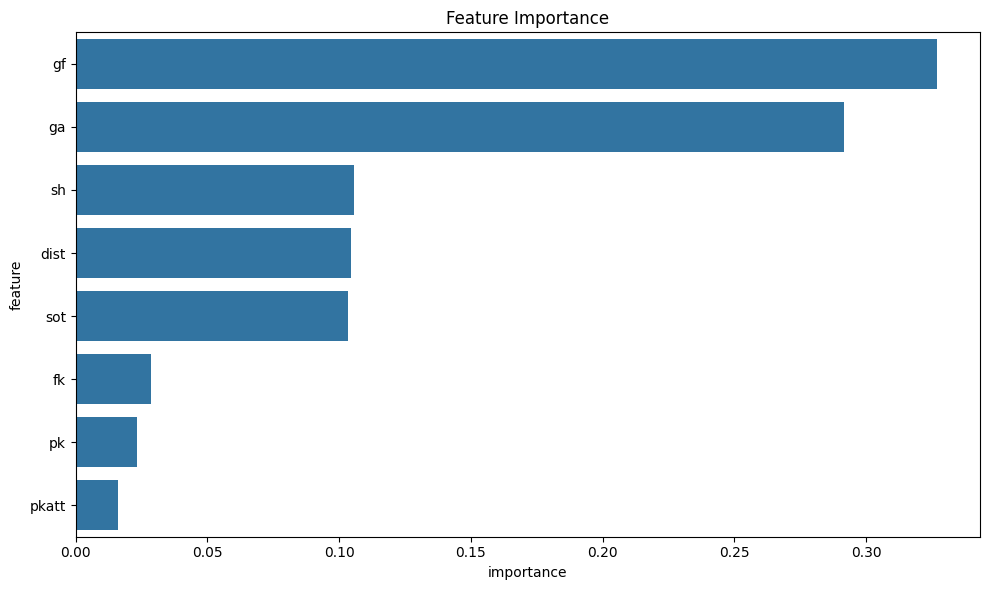


Team Performance:
team
Manchester City      1.657895
Arsenal              1.605263
Liverpool            1.526316
Aston Villa          1.263158
Tottenham Hotspur    1.210526
Chelsea              1.184211
Name: result, dtype: float64


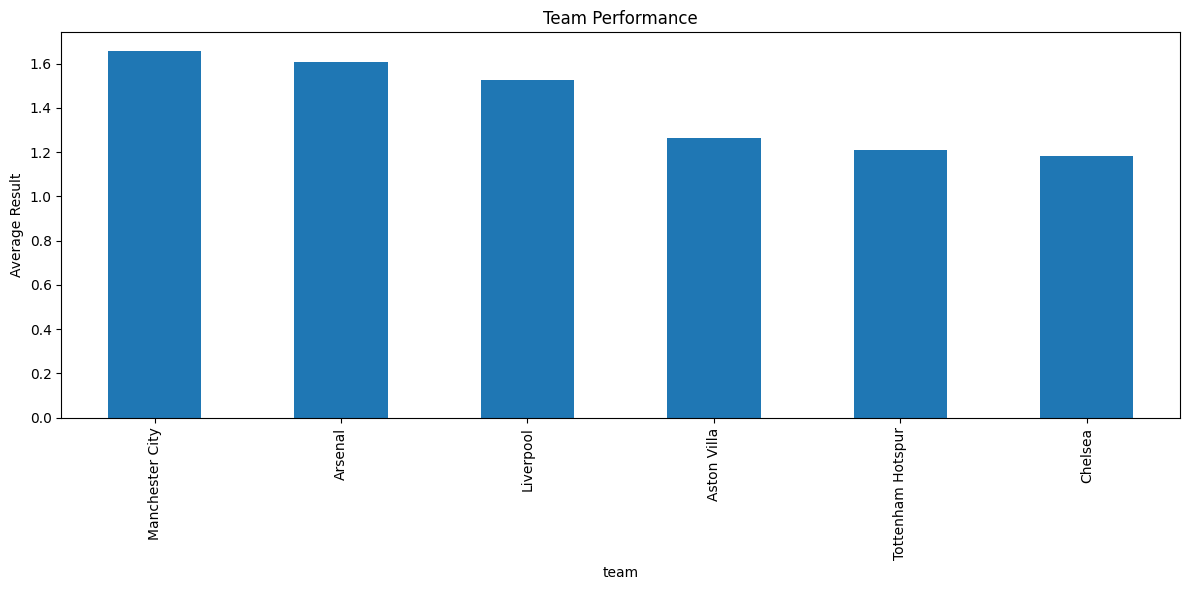

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
matches = pd.read_csv("matches.csv")

# Data preprocessing
matches['date'] = pd.to_datetime(matches['date'])
matches['result'] = matches['result'].map({'W': 2, 'D': 1, 'L': 0})

# Feature selection
features = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
X = matches[features]
y = matches['result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Analyze team performance
team_performance = matches.groupby('team')['result'].mean().sort_values(ascending=False)
print("\nTeam Performance:")
print(team_performance)

# Visualize team performance
plt.figure(figsize=(12, 6))
team_performance.plot(kind='bar')
plt.title('Team Performance')
plt.ylabel('Average Result')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()